In [1]:
# %matplotlib widget

In [2]:
import os

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting, datasets, surface, image
import seaborn as sns

from matplotlib import gridspec
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LinearSegmentedColormap
import itertools
from tqdm import tqdm

from sklearn.cluster import KMeans
from src.regress import ridge
from scipy import stats

## Functions

In [3]:
def _colorbar_from_array(array, threshold, cmap):
    """Generate a custom colorbar for an array.
    Internal function used by plot_img_on_surf
    array : np.ndarray
        Any 3D array.
    vmax : float
        upper bound for plotting of stat_map values.
    threshold : float
        If None is given, the colorbar is not thresholded.
        If a number is given, it is used to threshold the colorbar.
        Absolute values lower than threshold are shown in gray.
    kwargs : dict
        Extra arguments passed to _get_colorbar_and_data_ranges.
    cmap : str, optional
        The name of a matplotlib or nilearn colormap.
        Default='cold_hot'.
    """
    vmin = array.min()
    vmax = array.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmaplist = [cmap(i) for i in range(cmap.N)]

    if threshold is None:
        threshold = 0.

    # set colors to grey for absolute values < threshold
    istart = int(vmin)
    istop = int(norm(threshold, clip=True) * (cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)
    our_cmap = LinearSegmentedColormap.from_list('Custom cmap',
                                                 cmaplist, cmap.N)
    sm = plt.cm.ScalarMappable(cmap=our_cmap,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    return sm

In [4]:
def mkNifti(arr, mask, im, nii=True):
    out_im = np.zeros(mask.size, dtype=arr.dtype)
    inds = np.where(mask)[0]
    out_im[inds] = arr
    if nii:
        out_im = out_im.reshape(im.shape)
        out_im = nib.Nifti1Image(out_im, affine=im.affine)
    return out_im

In [5]:
def mkNifti2d(arr, mask):
    out_im = np.zeros((arr.shape[0], mask.size), dtype=arr.dtype)
    inds = np.where(mask)[0]
    out_im[:, inds] = arr
    return out_im

## Paths

In [6]:
process = 'components'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis'
data_dir = f'{top_dir}/data/raw'
out_dir = f'{top_dir}/data/interim'
figure_dir = f'{top_dir}/reports/figures/{process}'
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)

## Stuff

In [7]:
#Load mask
reliability = np.load(f'{out_dir}/Reliability/sub-all_reliability-mask.npy').astype('bool')
im = nib.load(f'{out_dir}/Reliability/sub-all_stat-rho_statmap.nii.gz')

rs = np.load(f'{out_dir}/VoxelPermutation/sub-all/sub-all_feature-all_rs-filtered.npy').astype('bool')
rs = mkNifti(rs, reliability, im, nii=False)
mask = np.logical_and(reliability, rs)

In [8]:
X = []

n_voxels = sum(mask)
for sid_ in range(4):
    sid = str(sid_+1).zfill(2)
    betas = np.load(f'{out_dir}/grouped_runs/sub-{sid}/sub-{sid}_train-data.npy')
    
    #Filter the beta values to the reliable voxels
    betas = betas[mask, :]
    
    #Mean center the activation within subject
    # offset_subject = betas.mean()
    # betas -= offset_subject

    if type(X) is list:
        X = betas.T
    else:
        X += betas.T
X /= 4 

In [9]:
df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
train = pd.read_csv(f'{data_dir}/annotations/train.csv')
df = df.merge(train)
df.sort_values(by=['video_name'], inplace=True)
df.drop(columns=['video_name'], inplace=True)
features = np.array(df.columns)

y = df.to_numpy()

In [10]:
coef, _ = ridge(X, y)

In [11]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(coef.T)
brain_map = mkNifti(cluster_labels+1, mask, im)

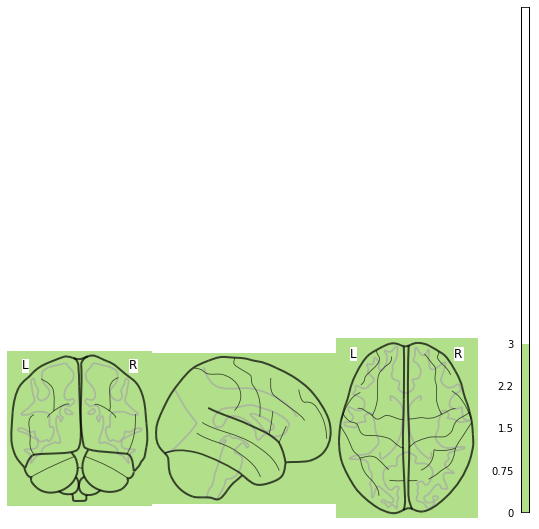

In [48]:
cmap = sns.color_palette('Paired', as_cmap=True)
cmap.colors = cmap.colors[:n_clusters]
cmap._lut = cmap._lut[:n_clusters]
# cmap.N = n_clusters
view = plotting.plot_glass_brain(brain_map, cmap=cmap,
                                 vmin=1., vmax=n_clusters,
                                 # symmetric_cbar=False,
                                 threshold=1., colorbar=True)

In [24]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
texture = {'left': [], 'right': []}
for hemi in ['left', 'right']: 
    arr = surface.vol_to_surf(brain_map, fsaverage[f'pial_{hemi}'],
                                       interpolation='nearest')
    # arr[arr < .9] = 0 
    # for i in range(1, n_clusters-1):
    #     arr[(arr > i+.1) & (arr < i+0.9)] = 0 
    texture[hemi] = arr.astype('int')

In [25]:
hemi = 'right'
view = plotting.view_surf(fsaverage[f'infl_{hemi}'],
                       surf_map=texture[hemi],
                          symmetric_cmap=False,
                       vmin=1., vmax=n_clusters,
                          threshold=1.,
                       cmap=cmap,
                       bg_map=fsaverage[f'sulc_{hemi}'])
view.open_in_browser()

/Applications/anaconda3/envs/nibabel/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '


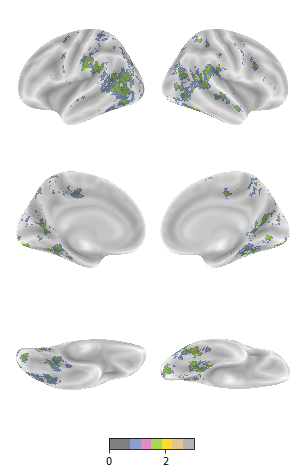

In [15]:
title = None
modes=['lateral', 'medial', 'ventral']
hemis=['left', 'right']
threshold=1
output_file=None
colorbar=True
vmax=None
kwargs={}

cbar_h = .25
title_h = .25 * (title is not None)
w, h = plt.figaspect((len(modes) + cbar_h + title_h) / len(hemis))
# w, h = w*2, h*2
fig = plt.figure(figsize=(w, h), constrained_layout=False)
height_ratios = [title_h] + [1.] * len(modes) + [cbar_h]
grid = gridspec.GridSpec(
    len(modes) + 2, len(hemis),
    left=0., right=1., bottom=0., top=1.,
    height_ratios=height_ratios, hspace=0.0, wspace=0.0)
axes = []
for i, (mode, hemi) in enumerate(itertools.product(modes, hemis)):
    ax = fig.add_subplot(grid[i + len(hemis)], projection="3d")
    axes.append(ax)
    plotting.plot_surf_roi(fsaverage[f'infl_{hemi}'],
                           roi_map=texture[hemi],
                           hemi=hemi, view=mode,
                           bg_map=fsaverage[f'sulc_{hemi}'],
                           bg_on_data=True,
                           darkness=.5, threshold=1,
                           cmap=cmap,
                           axes=ax)
    # We increase this value to better position the camera of the
    # 3D projection plot. The default value makes meshes look too small.
    ax.dist = 7

if colorbar:
    array = np.hstack((texture['left'], texture['right']))
    sm = _colorbar_from_array(array, threshold, get_cmap(cmap))

    cbar_grid = gridspec.GridSpecFromSubplotSpec(3, 3, grid[-1, :])
    cbar_ax = fig.add_subplot(cbar_grid[1])
    axes.append(cbar_ax)
    fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

In [16]:
for i in range(n_clusters):
    vals = kmeans.cluster_centers_[i,:]
    vals = (vals - vals.mean()) / vals.std()
    sort_indices = vals.argsort()
    sort_indices = np.flip(sort_indices)
    print(pd.DataFrame({'cluster centers': vals[sort_indices],
                       'features': features[sort_indices]}))
    print()

    cluster centers        features
0          1.947660      facingness
1          0.861548   communication
2          0.849540          indoor
3          0.721880    joint action
4          0.125328       dominance
5          0.116464         valence
6          0.069758     cooperation
7          0.050097        intimacy
8         -0.682284         arousal
9         -1.077250         expanse
10        -1.256284  agent distance
11        -1.726456    transitivity

    cluster centers        features
0          2.127122          indoor
1          1.380406    transitivity
2          0.456497  agent distance
3          0.235556         arousal
4          0.133417         expanse
5         -0.008566        intimacy
6         -0.088344         valence
7         -0.210775       dominance
8         -0.296281     cooperation
9         -0.812068    joint action
10        -1.116230   communication
11        -1.800733      facingness

    cluster centers        features
0          0.865468       